In [705]:
# import a custom plotting library
import some_plotters as plotter

# import autograd functionality
import autograd.numpy as np

# import path to datasets
datapath = 'datasets/'

# # this is needed to compensate for %matplotl+ib notebook's tendancy to blow up images when plotted inline
# from matplotlib import rcParams
# rcParams['figure.autolayout'] = True
# %matplotlib notebook

# autoreload function - so if anything behind the scenes is changeed those changes
# are reflected in the notebook without having to restart the kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### <span style="color:#a50e3e;">Exercise 1: </span>  Train an unregularized PID controller for the cruise control problem

In this exercise you will tune the parameters of a PID controller automatically so that the trained Imitation Model (that you trained in homework 1 exercise 1) matches the example set point sequence shown below relatively closely.  

In [706]:
import autograd.numpy as np
from autograd import value_and_grad 
from autograd.misc.flatten import flatten_func
import matplotlib.pyplot as plt

# pip install import_ipynb
import import_ipynb
import homework_2_helper_functions
import copy

<IPython.core.display.Javascript object>


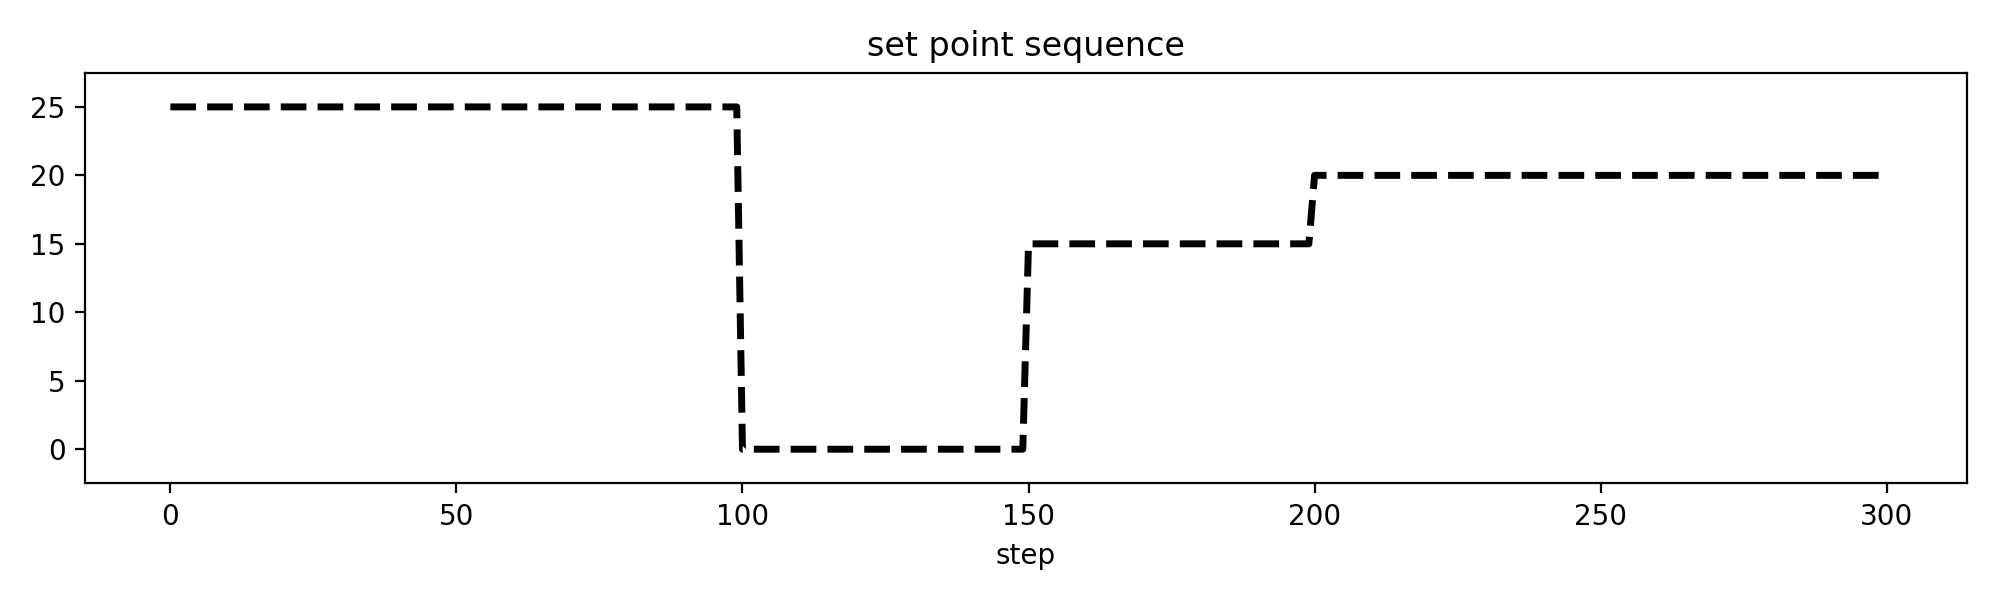

In [707]:
# load in set point sequence
csvname = 'datasets/cruise_setpoints.csv'
set_points = np.loadtxt(csvname,delimiter = ',')[np.newaxis,:]

# plot set point sequence
plotter.plot_setpoints(set_points)

Implement a `Pythonic` version of the PID controller Least Squares cost function discussed in the [course notes](https://jermwatt.github.io/control-notes/presentations/pid_control/pid_control_part_1.slides.html#/).  You should be able to learn an optimal action / state sequence pair so that your system model responds fairly well to the input set point sequence.  The image below shows the results of an action/state sequence pair learned by a fully tuned PID controller.  The top panel shows the set point sequence in dashed black, with the state sequence defined by the controller in blue.  The bottom panel shows the corresponding action sequence defined by the controller.

<figure>
<p>
<img src= 'images/pid_result.png' width="150%" height="150%" alt=""/>
</p>
</figure>

A few notes: 

- You will need a fully trained Imitation Model - which you created in Exercise 1 of Homework 1 - for this exercise.  This model - for example - clips actions between $\left[-50,100\right]$.


- Even though a PID controller is technically a Recurrent Network (which can be slow to train), here we only deal with a fairly small dataset of set points and there only 4 parameters to tune - so you can apply the simplest kind of first order algorithm to properly minimize the controller cost (e.g., a full batch gradient descent optimizer).  However I've found that simpler approaches - like the zero-order coordinate descent algorithm discussed in the `homework_2_helper_functions.ipynb` notebook.


- For this exercise you need not worry about cross-validating, simply tune it as best as you can.  The result above was achieved with less than 50 steps of zero order coordinate descent.


- Examining the actions (the amount we depress the pedtal), notice how uncomfortable the driving experience above would be when transitioning between speed levels.  This would be crazy.  If we really wanted this controller to perform well we would need to *regularize* our Least Squares cost to avoid this kind of crazy behavior.  But you don't need to worry about that here.

In [593]:
# learned from class notes
# a simple implementation of a PID controller
def PID_controller(e_t,h_t,d_t,w):    
    # note here in terms of inputs
    # e_t = current error
    # h_t = integral of error
    # d_t = derivative of error
    return w[0] + w[1]*e_t + w[2]*h_t + w[3]*d_t

In [594]:
# taken from homework 1
# NOTE: could not copy same results without manually entering in best weights. Tried importing files & work but it didn't work the same
# results from homework 1:
# Best weights:
# [[0.1715823 ]
#  [0.93787464]
#  [0.00940438]]
w = [0.1715823, 0.93787464, 0.00940438]

def tuned_system_model(s_t,a_t,w):
    return w[0] + w[1]*s_t + w[2]*a_t

# from jeremy:
# tuned_system_model = lambda s_t,a_t: system_model(s_t,a_t,w_best)


In [595]:
# learned from class notes
# loop for evaluating control model over all input/output action/state pairs
# Our inputs here:
# s_1 - the initial condition state
# x - sequence of training set points
# w - the control model parameters
def control_loop(x,w):
    # initialize key variables and containers
    s_1 = 0
    s_t = copy.deepcopy(s_1)
#     s_t = [0.0,0.0] #doesn't work
    h_t = 0
    d_t = 0
    frac = 1/float(np.size(x))
    action_history = []
    state_history = [s_t]
    error_history = []
    
    # loop over training set points and run through controller, then 
    # system models
    for t in range(np.size(x) - 1):
        # get current set point
        x_t = x[:,t]

        # update error
        e_t = x_t - s_t
        error_history.append(e_t)
        
        # update integral of error
        h_t = h_t + frac*e_t
        
        # update derivative of error 
        if t > 0:
            d_t = frac*(error_history[-1] - error_history[-2])
            
        # send error, integral, and derivative to PID controller
        a_t = PID_controller(e_t,h_t,d_t,w)
        
        # clip a_t to match system specifications?
        # cannot say a_t = a_t if >-50 or <100... or can you?
#         if a_t <= 100 and a_t >= -50:
#             a_t = a_t
#         else:
#             a_t = 0
        # from jeremy watt:
        # clip inputs to -50% to 100%
        if a_t >= 100.0:
            a_t = 100.0
        if a_t <= -50.0:
            a_t = -50.0
        
        # send action to system model
        s_t = tuned_system_model(s_t,a_t,w)
        
        # store state output, and actions (for plotting)
        state_history.append(s_t)
        action_history.append(a_t)

    # transition to arrays
    state_history = np.array(state_history)[np.newaxis,:]
    action_history = np.array(action_history)[np.newaxis,:]
    
    # return velocities and control history
    return state_history,action_history

In [596]:
# learned from class notes
# an implementation of the least squares cost for PID controller tuning
# note here: s is an (1 x T) array and a an (1 x T-1) array
def least_squares(w,x):
    # system_loop - runs over all action-state pairs and produces entire
    # state prediction set
    state_history,action_history = control_loop(x,w)

    # compute least squares error between real and predicted states
    cost = np.sum((state_history[:,1:] - x[:,1:])**2)
    return cost/float(x.shape[1]-1)

In [681]:
# homework_2_helper_functions.coordinate_descent(g,w_init,alpha,max_its,verbose)

In [697]:
# taken from homework 1
# g = lambda w,s=s_normalizeD,a=a_normalizeD: LSfunc(w,s,a)
g = lambda w,x=set_points: least_squares(w,x)

w_hist,train_hist = homework_2_helper_functions.coordinate_descent(g,
                                                                   w_init=np.random.randn(4,1),
                                                                   alpha=10**(0),
                                                                   max_its=50,
                                                                   verbose=False)

# index of the minimum cost value attained
ind = np.argmin(train_hist)

# corresponding weights and cost evaluation
w_best = w_hist[ind]
print("Best weights:\n" + str(w_best))
g_best = train_hist[ind]
print("\nBest cost:\n" + str(g_best))

Best weights:
[[ -1.17342059]
 [  1.16129056]
 [  1.60158704]
 [-49.89322927]]

Best cost:
[6.07876686]


<IPython.core.display.Javascript object>


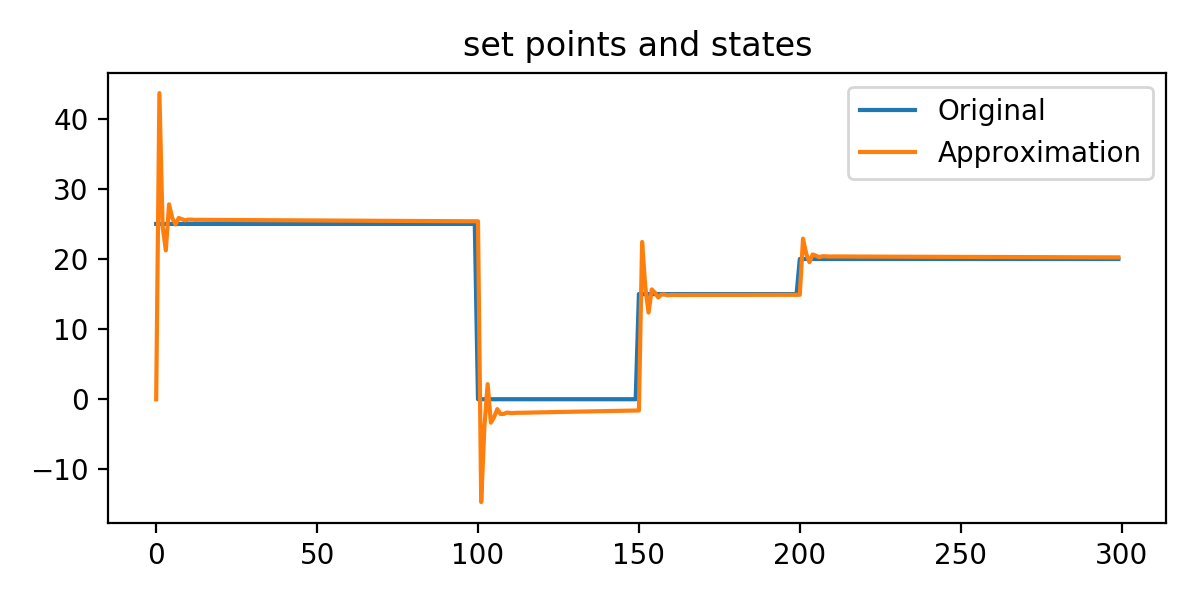

In [702]:
# taken from homework 1
state_history,action_history = control_loop(x=set_points,
                                            w=w_best)

plt.figure(num=1, figsize = (6,3))
plt.title("set points and states")
plt.plot(set_points.T)
plt.plot(state_history.T)
# plt.plot(action_history.flatten().T)
plt.legend(["Original", "Approximation"])
plt.show()

<IPython.core.display.Javascript object>


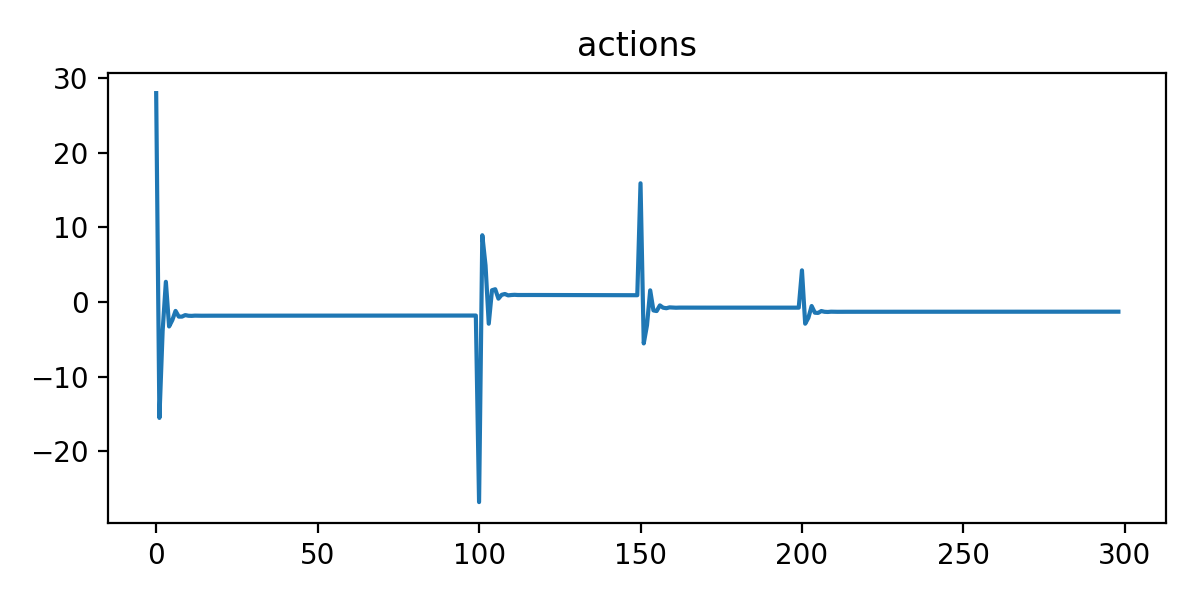

In [699]:
plt.figure(num=2, figsize = (6,3))
plt.plot(action_history.flatten().T)
plt.title("actions")
plt.show()

<IPython.core.display.Javascript object>


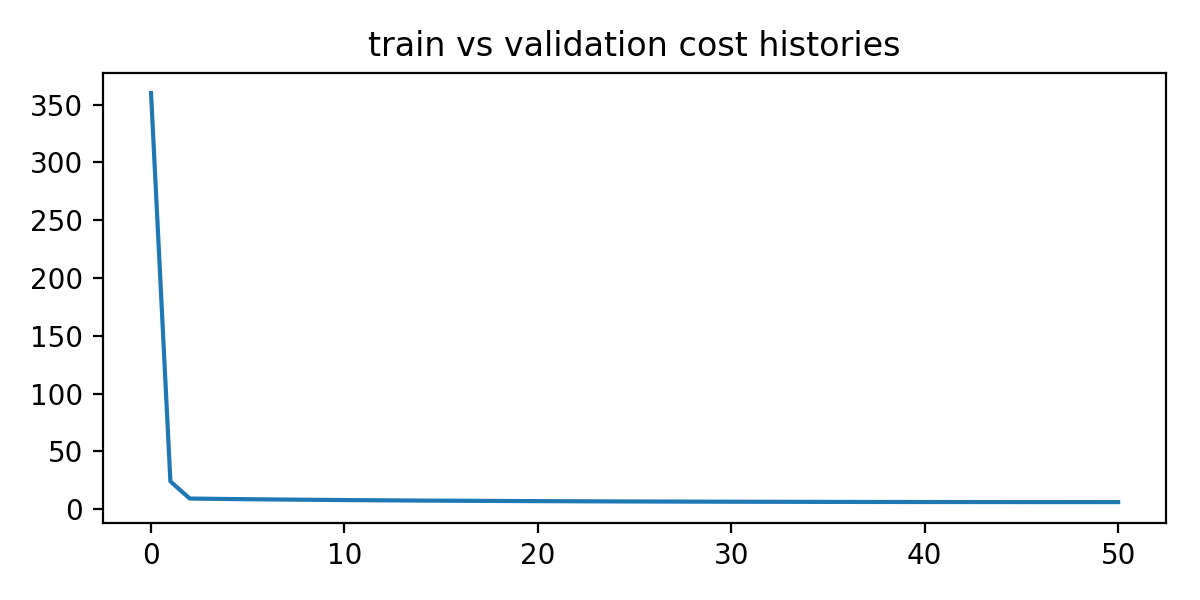

In [704]:
plt.figure(num=3, figsize = (6,3))
plt.plot(train_hist)
plt.title("train vs validation cost histories")
# axes = plt.gca()
# axes.set_xlim([-1,55])
# axes.set_ylim([5,20])
plt.show()